In [17]:
import importlib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import json
import sys
import statsmodels.api as sm
import os
from tensorflow import keras
from tensorflow.keras import layers

import kad.visualization.visualization as visualization
from kad.kad_utils import kad_utils
from kad.kad_utils.kad_utils import customize_matplotlib
import kad.model.autoencoder_model as autoencoder_model
from kad.model.sarima_model import SarimaModel
import kad.models_evaluation.models_evaluator as models_evaluator

sys.path.insert(1, '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector')
print(sys.path)

import kad.ts_analyzer.ts_analyzer as ts_analyzer
from kad.model import i_model
from sklearn.model_selection import train_test_split

customize_matplotlib()

['/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/notebooks', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/venv/lib/python3.8/site-packages', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/venv/lib/python3.8/site-packages/IPython/extensions', '/home/maciek/.ipython', '/snap/pycharm-professional/242/plugins/python/helpers/pydev', '/snap/pycharm-professional/242/plugins/python/helpers-pro/jupyter_debug']


In [18]:
data_dir = "data/archive/"
file_dir = "artificialWithAnomaly"
file_name = "artificialWithAnomaly/art_daily_jumpsup.csv"

file_path = os.path.join(data_dir, file_dir, file_name)

original_df = pd.read_csv(
    file_path, parse_dates=True, index_col="timestamp"
)

original_df = original_df.resample("h").agg(np.mean)

with open("data/archive/combined_windows.json") as f:
    true_anomalies = json.load(f)

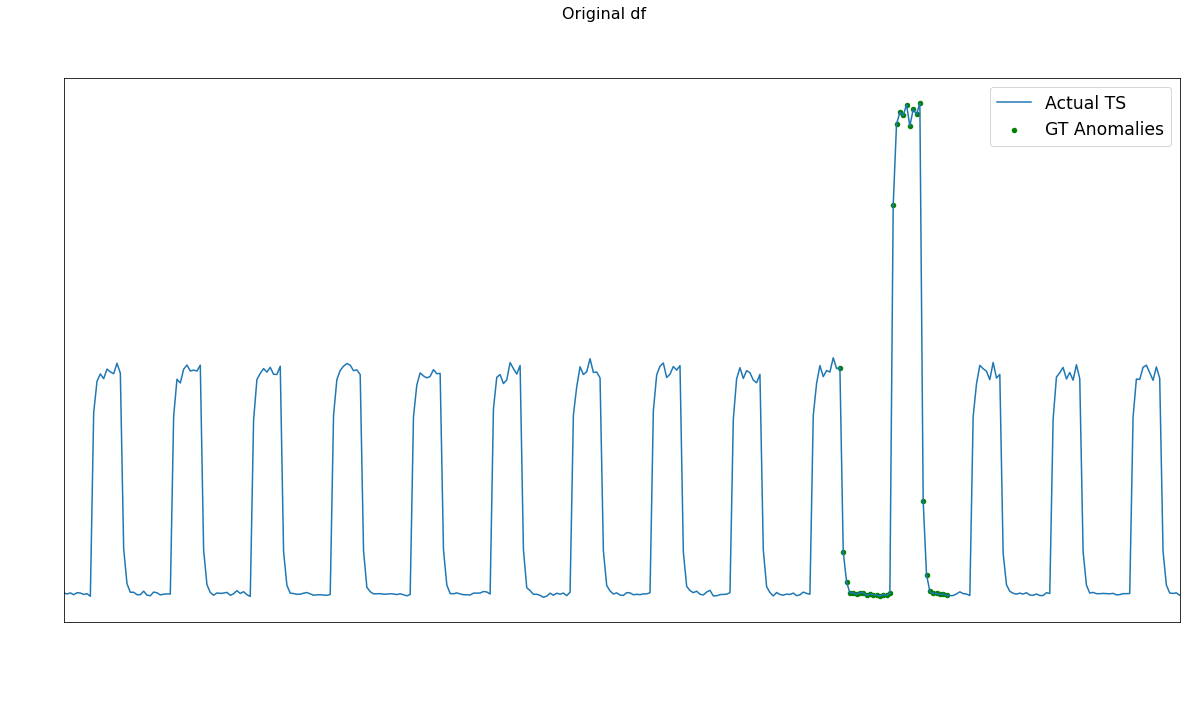

In [19]:
X_LABEL = "timestamp"
ts_analyzer = importlib.reload(ts_analyzer)

true_anomalies_ranges = true_anomalies[file_name]

ground_true_anomalies_df = pd.DataFrame()
for anom_range in true_anomalies_ranges:
    ground_true_anomalies_df = ground_true_anomalies_df.append(original_df.loc[anom_range[0]:anom_range[1]])

preprocessed_df = original_df.copy()
preprocessed_df["gt_is_anomaly"] = [idx in ground_true_anomalies_df.index  for idx in original_df.index.tolist()]

visualization.visualize(results_df=preprocessed_df, metric_name="value", title="Original df")

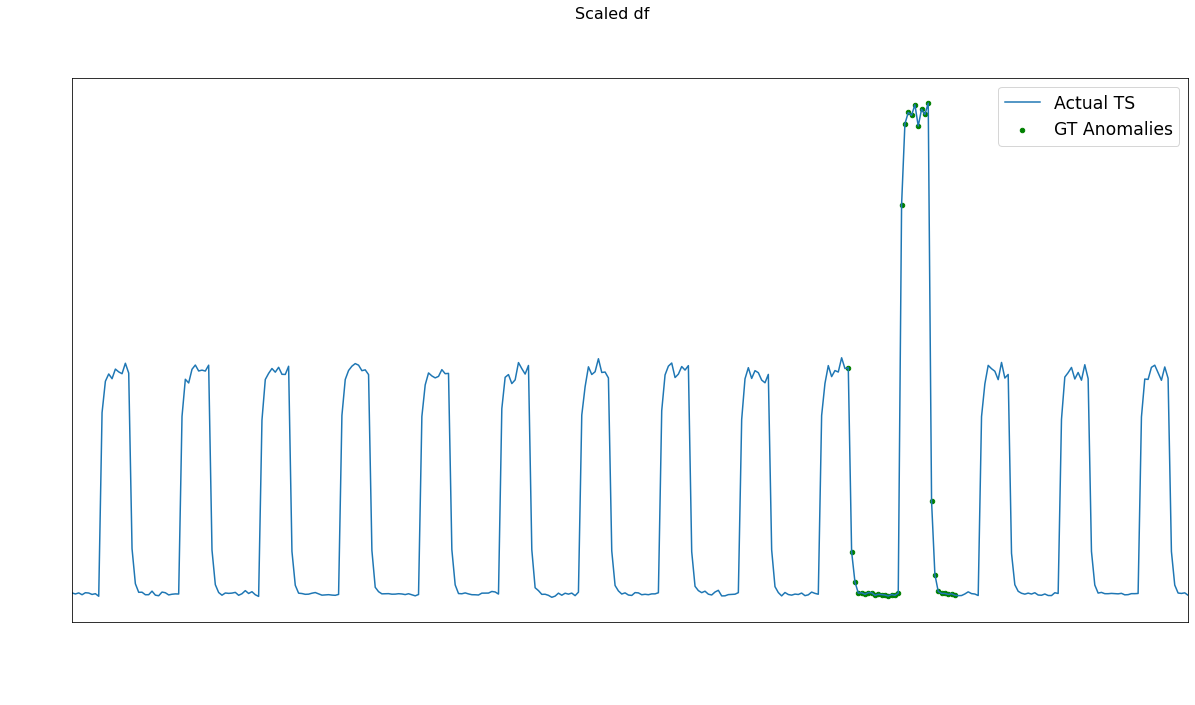

In [20]:
scaler = MinMaxScaler(feature_range=(-1, 0))
preprocessed_df["value"] = scaler.fit_transform(preprocessed_df.values)

visualization.visualize(results_df=preprocessed_df, metric_name="value", title="Scaled df")

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_30 (Conv1D)           (None, 6, 32)             256       
_________________________________________________________________
dropout_30 (Dropout)         (None, 6, 32)             0         
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 3, 16)             3600      
_________________________________________________________________
conv1d_transpose_45 (Conv1DT (None, 6, 16)             1808      
_________________________________________________________________
dropout_31 (Dropout)         (None, 6, 16)             0         
_________________________________________________________________
conv1d_transpose_46 (Conv1DT (None, 12, 32)            3616      
_________________________________________________________________
conv1d_transpose_47 (Conv1DT (None, 12, 1)           

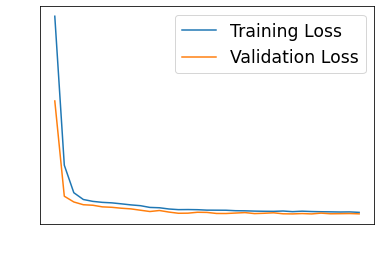

                        value residuals  anom_score
timestamp                                          
2014-04-01 00:00:00 -0.991224      None         NaN
2014-04-01 01:00:00 -0.993281      None         NaN
2014-04-01 02:00:00 -0.991139      None         NaN
2014-04-01 03:00:00 -0.994822      None         NaN
2014-04-01 04:00:00 -0.990730      None         NaN
...                       ...       ...         ...
2014-04-10 14:00:00 -0.544182  0.060592    0.042432
2014-04-10 15:00:00 -0.515331  0.059515    0.040518
2014-04-10 16:00:00 -0.537102  0.051635    0.026501
2014-04-10 17:00:00 -0.535422  0.046669    0.017667
2014-04-10 18:00:00 -0.907737  0.053708    0.030188

[235 rows x 3 columns]
                        value residuals  anom_score is_anomaly
timestamp                                                     
2014-04-01 00:00:00 -0.991224      None         NaN       None
2014-04-01 01:00:00 -0.993281      None         NaN       None
2014-04-01 02:00:00 -0.991139      None         

/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/kad/model/autoencoder_model.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.result_df["residuals"] = np.append(np.array([None for _ in range(self.time_steps)]), train_mae_loss)
/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/kad/model/autoencoder_model.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.result_df[ANOM_SCORE_COLUMN] = calculate_anomaly_score(self.result_df["residuals"])
/home/maciek/Documents/Magister

In [50]:
kad_utils = importlib.reload(kad_utils)
autoencoder_model = importlib.reload(autoencoder_model)
model: i_model.IModel = autoencoder_model.AutoEncoderModel(time_steps=12)

values_df = preprocessed_df[["value"]]
train_df, test_df = train_test_split(values_df, shuffle=False, train_size=0.7)
model.train(train_df)

results_df = pd.DataFrame()
SAMPLES_TO_PREDICT = 60
for i in range(0, len(test_df), SAMPLES_TO_PREDICT):
    if len(test_df.iloc[i:i+SAMPLES_TO_PREDICT]) < SAMPLES_TO_PREDICT:
        break
    results_df = model.test(test_df.iloc[i:i+SAMPLES_TO_PREDICT])

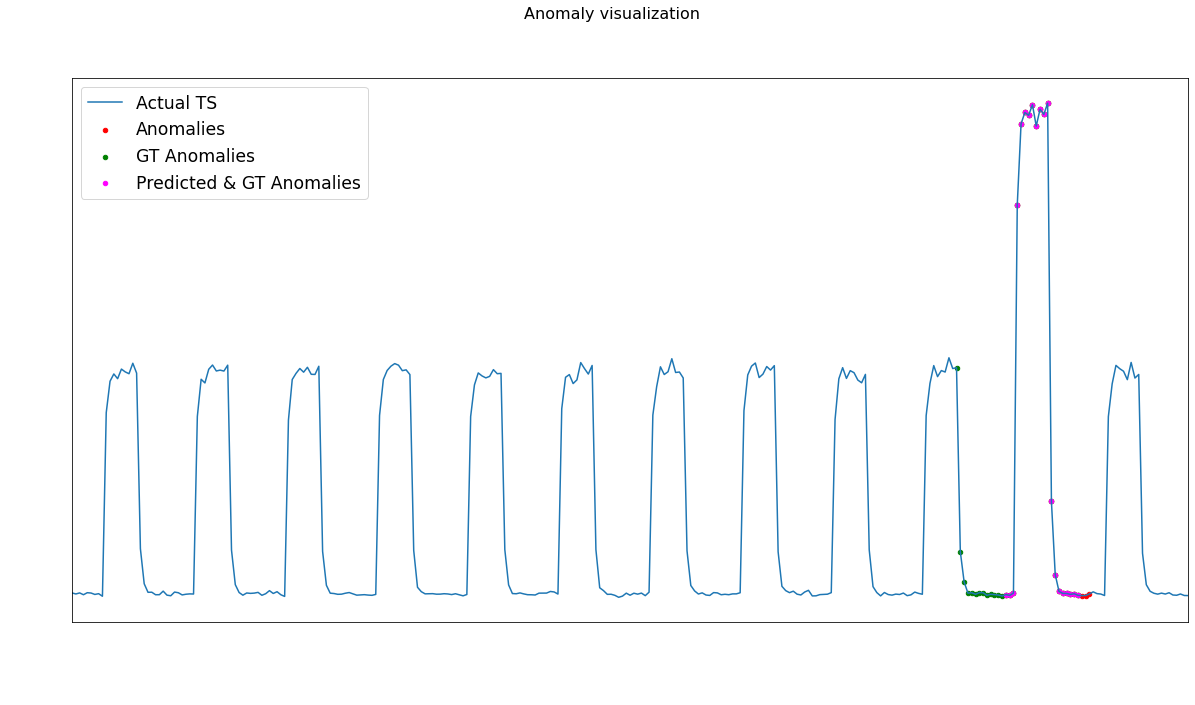

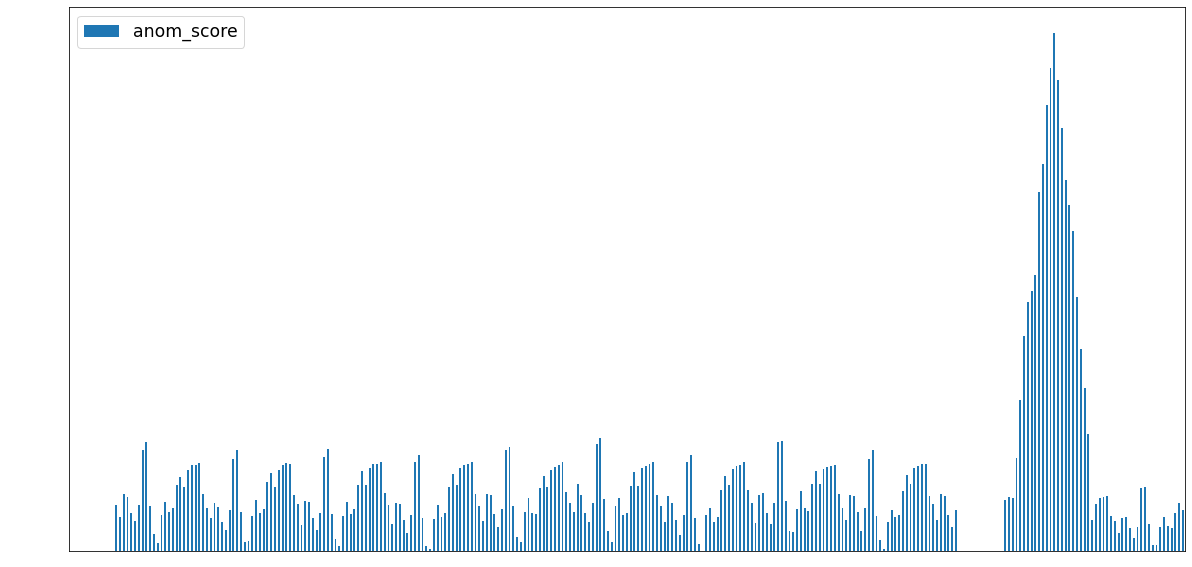

In [54]:
evaluation_df = results_df.copy()
evaluation_df["gt_is_anomaly"] = preprocessed_df["gt_is_anomaly"]
visualization = importlib.reload(visualization)
visualization.visualize(evaluation_df, "value")

<ipython-input-55-d1b2c251246a>:1: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  final_df = evaluation_df.loc[test_df.index & evaluation_df.index][12:]


Accuracy:  0.9375
Avg precision:  0.9249710815500287


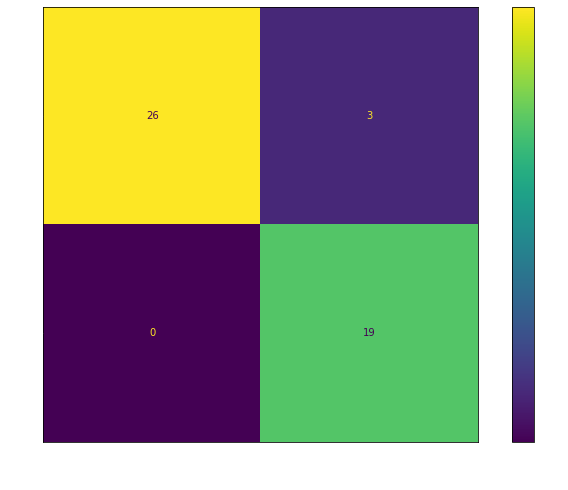

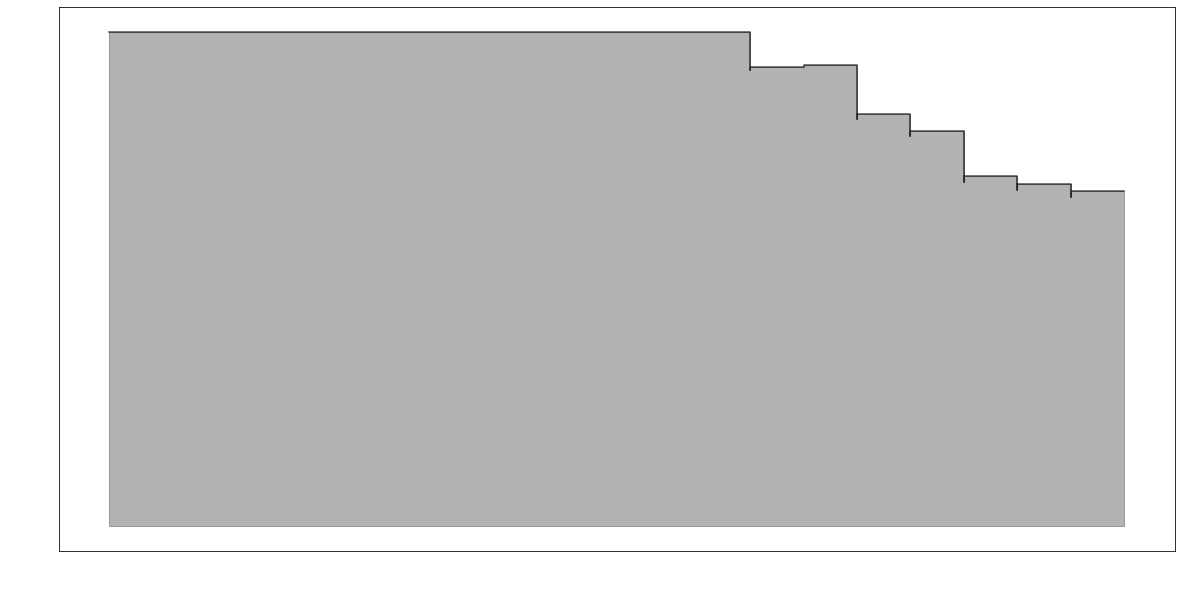

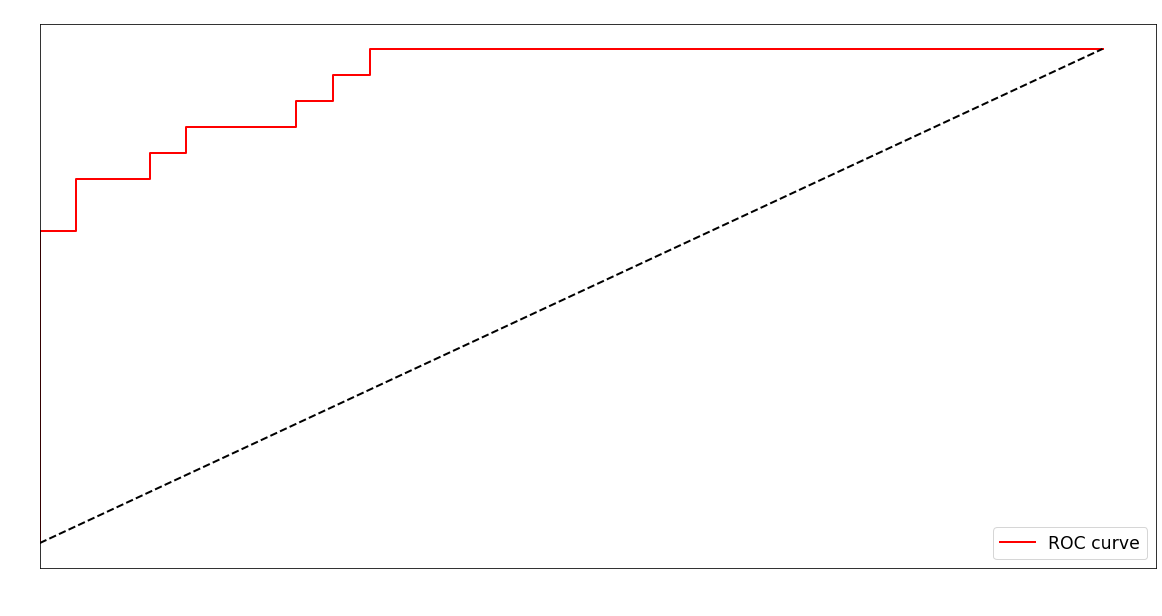

In [55]:
final_df = evaluation_df.loc[test_df.index & evaluation_df.index][12:]
evaluator = models_evaluator.ModelsEvaluator(df=final_df)

print("Accuracy: ", evaluator.get_accuracy())
print("Avg precision: ", evaluator.get_average_precision())

evaluator.plot_confusion_matrix()


evaluator.plot_precision_recall_curve()
evaluator.plot_roc()
